In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import plotly.plotly as py
from plotly.graph_objs import *

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 8)

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['Annotation', 'Figure']
`%matplotlib` prevents importing * from pylab and numpy



In [22]:
pacs = pd.read_csv('Campaign_Finance_data/pacs_all.csv', encoding = "ISO-8859-1")
conginvest = pd.read_csv('Goal1_PFD_1of3.csv', encoding = "ISO-8859-1")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
cmte = pd.read_csv('Campaign_Finance_data/cmtes_all.csv', encoding = "ISO-8859-1")
pacs = pacs.merge(cmte[['CmteID', 'PACShort']], left_on='PACID', right_on='CmteID', how='left').drop('CmteID', axis=1)

temp = pacs[['Cycle','PACID','PACShort']].drop_duplicates()

print('Number of PACIDs with multiple organization names: ',
    len(temp.groupby(['Cycle','PACID'])['PACShort'].size().reset_index(). \
        query('PACShort > 1'))) #16723 

del temp, cmte

In [23]:
# RealCodeOut is congresspeople investing
# RealCodeIn is industry giving money to congresspeople
conginvest = conginvest[['CID', 'RealCode']].rename(columns={'RealCode':'RealCodeOut'}). \
    groupby(['CID','RealCodeOut']).size().reset_index(name='NumInvestments')
pacs = pacs[['Cycle', 'CID', 'PACID', 'Amount', 'RealCode']].rename(columns={'RealCode':'RealCodeIn'})

In [24]:
contributions = pacs. \
    groupby(['PACID', 'RealCodeIn', 'CID'])['Amount']. \
    sum().reset_index()

print(len(contributions))
contributions.head()

920282


,PACID,RealCodeIn,CID,Amount
0,C00000026,H1500,N00000209,500
1,C00000026,H1500,N00000659,1000
2,C00000026,H1500,N00000756,8526
3,C00000026,H1500,N00000817,500
4,C00000026,H1500,N00001022,100


In [26]:
df = contributions.merge(conginvest, 
                         left_on=['CID','RealCodeIn'], right_on=['CID','RealCodeOut'], how='left'). \
                        drop('RealCodeOut', axis=1). \
                        rename(columns={'RealCodeIn': 'RealCode'})
df.dropna().head()

,PACID,RealCode,CID,Amount,NumInvestments
78,C00000042,M2300,N00000561,12500,19.0
87,C00000042,M2300,N00001489,3500,1.0
99,C00000042,M2300,N00002097,1000,4.0
103,C00000042,M2300,N00002315,4000,10.0
105,C00000042,M2300,N00002328,2000,5.0


In [27]:
industry_df = df.groupby(['RealCode', 'CID'])['Amount', 'NumInvestments']. \
    sum().reset_index()

industry_df.dropna().head()

,RealCode,CID,Amount,NumInvestments
21,A0000,N00004645,1000,3.0
29,A0000,N00005559,5500,6.0
31,A0000,N00006263,2000,2.0
108,A1000,N00001329,4000,1.0
113,A1000,N00001510,7000,9.0


In [97]:
industry_subset = pd.DataFrame(industry_df.dropna()[:10])
G = nx.from_pandas_dataframe(industry_subset, 'RealCode', 'CID', 'Amount',
                             create_using=nx.MultiDiGraph())
H = nx.from_pandas_dataframe(industry_subset, 'CID', 'RealCode', 'NumInvestments',
                             create_using=nx.MultiDiGraph())
F = nx.compose(G, H)


D = nx.from_pandas_dataframe(industry_subset, 'RealCode', 'CID', ['Amount', 'NumInvestments'])
nx.write_graphml(D, 'investmentlinks.graphml')

In [100]:

#node_size 

ValueError: DataFrame constructor not properly called!

In [66]:
print(F['A0000']['N00004645'], F['N00004645']['A0000'])

# G.add_edge(relkey[1], relkey[0],weight=int(Amount))

{0: {'Amount': 1000}} {0: {'NumInvestments': 3.0}}


ValueError: too many values to unpack (expected 2)

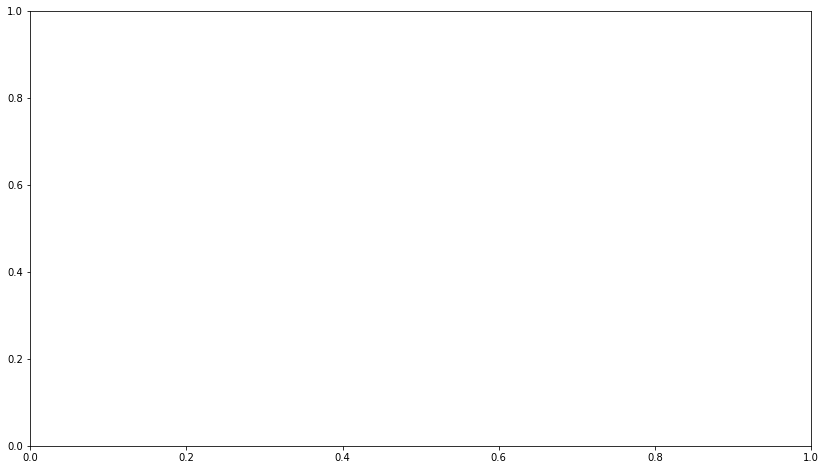

In [76]:
pos = nx.spring_layout(H, scale=2)
nx.draw_networkx(H, pos)

edge_labels = nx.get_edge_attributes(H,'NumInvestments')
nx.draw_networkx_edge_labels(H, pos, edge_labels = edge_labels)#, label_pos=0.5)

plt.show()

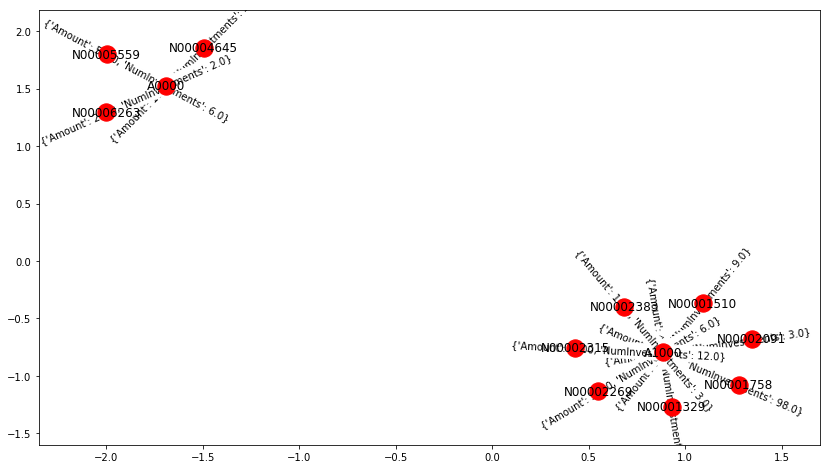

In [95]:
pos = nx.spring_layout(D, scale=2)
nx.draw_networkx(D, pos)

nx.draw_networkx_edge_labels(D, pos)

plt.figure(figsize=(12,12), dpi=80)
plt.savefig('graph.pdf')